# miχpods


- [ ] test out hvplot
- [ ] build LES catalog
- [ ] bootstrap error on mean, median?
- [ ] switch to daily data?
- [x] add TAO N2, Tz, S2
- [ ] add TAO χpods
- [ ] move enso_transition_mask to mixpods


## References

Warner & Moum (2019)

## Setup

In [ ]:
%load_ext watermark

import os

import cf_xarray
import dask
import dcpy
import distributed
import flox.xarray
import hvplot.xarray
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

import pump
from pump import mixpods

dask.config.set({"array.slicing.split_large_chunks": False})
mpl.rcParams["figure.dpi"] = 140 
xr.set_options(keep_attrs=True)

gcmdir = "/glade/campaign/cgd/oce/people/bachman/TPOS_1_20_20_year/OUTPUT/"  # MITgcm output directory
stationdirname = gcmdir

%watermark -iv

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
numpy      : 1.22.4
dcpy       : 0.1.dev360+g65bcf1a
xarray     : 2022.6.0rc0
dask       : 2022.6.1
flox       : 0.5.8.dev1+gc387edc
sys        : 3.10.5 | packaged by conda-forge | (main, Jun 14 2022, 07:04:59) [GCC 10.3.0]
hvplot     : 0.8.0
distributed: 2022.6.1
pandas     : 1.4.3
matplotlib : 3.5.2
pump       : 0.1
json       : 2.0.9
ipywidgets : 7.7.1
cf_xarray  : 0.7.2



In [ ]:
import ncar_jobqueue

if "client" in locals():
    client.close()
    del client
if "cluster" in locals():
    cluster.close()

#env = {"OMP_NUM_THREADS": "3", "NUMBA_NUM_THREADS": "3"}

# cluster = distributed.LocalCluster(
#    n_workers=8,
#    threads_per_worker=1,
#    env=env
# )

if "cluster" in locals():
    del cluster

#cluster = ncar_jobqueue.NCARCluster(
#    project="NCGD0011",
#    scheduler_options=dict(dashboard_address=":9797"),
#)
# cluster = dask_jobqueue.PBSCluster(
#    cores=9, processes=9, memory="108GB", walltime="02:00:00", project="NCGD0043",
#    env_extra=env,
# )

import dask_jobqueue

cluster = dask_jobqueue.PBSCluster(
    cores=1, # The number of cores you want
    memory='23GB', # Amount of memory
    processes=1, # How many processes
    queue='casper', # The type of queue to utilize (/glade/u/apps/dav/opt/usr/bin/execcasper)
    local_directory='$TMPDIR', # Use your local directory
    resource_spec='select=1:ncpus=1:mem=23GB', # Specify resources
    project='ncgd0011', # Input your project ID here
    walltime='02:00:00', # Amount of wall time
    interface='ib0', # Interface to use
)
cluster.scale(jobs=4)

/glade/u/home/dcherian/miniconda3/envs/pump/lib/python3.10/site-packages/distributed/node.py:180: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 45295 instead
  warnings.warn(


In [ ]:
client = distributed.Client(cluster)
client

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/dcherian/proxy/45295/status,
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/dcherian/proxy/45295/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.12.206.63:39935,Workers: 0
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/dcherian/proxy/45295/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [ ]:
import gsw_xarray
import dcpy

/glade/u/home/dcherian/miniconda3/envs/pump/lib/python3.10/site-packages/xarray/core/dataset.py:248: UserWarning: The specified Dask chunks separate the stored chunks along dimension "depth" starting at index 58. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
/glade/u/home/dcherian/miniconda3/envs/pump/lib/python3.10/site-packages/xarray/core/dataset.py:248: UserWarning: The specified Dask chunks separate the stored chunks along dimension "time" starting at index 139586. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
/glade/u/home/dcherian/miniconda3/envs/pump/lib/python3.10/site-packages/xarray/core/dataset.py:248: UserWarning: The specified Dask chunks separate the stored chunks along dimension "longitude" starting at index 2. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(


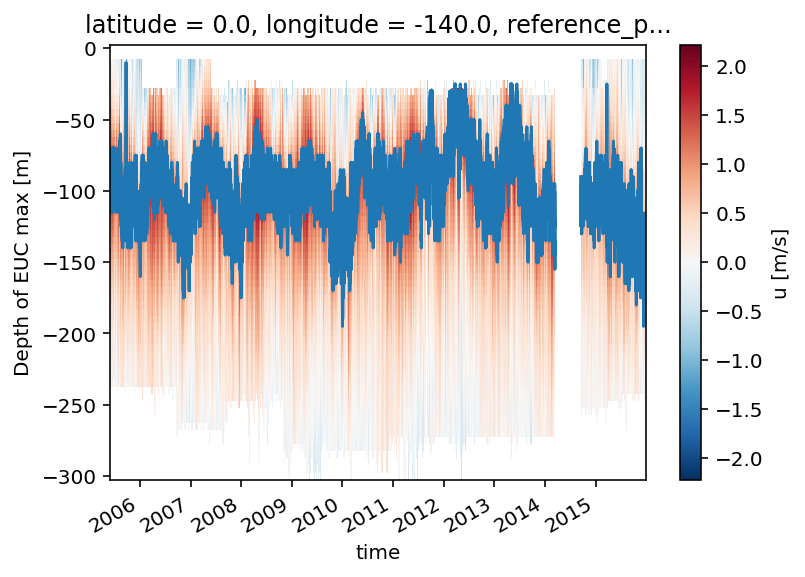

In [ ]:
tao_gridded = (
    xr.open_dataset(
        os.path.expanduser("~/work/pump/zarrs/tao-gridded-ancillary.zarr"), chunks="auto", engine="zarr"
    )
    .sel(longitude=-140, time=slice("2005-Jun", "2015"))
)
tao_gridded["depth"].attrs["axis"] = "Z"
# eucmax exists
tao_gridded.coords["eucmax"] = pump.calc.get_euc_max(tao_gridded.u.reset_coords(drop=True), kind="data")
#pump.calc.calc_reduced_shear(tao_gridded)
tao_gridded.coords["enso_transition"] = pump.obs.make_enso_transition_mask().reindex(time=tao_gridded.time, method="nearest")
tao_gridded.u.cf.plot()
tao_gridded.eucmax.plot()

In [ ]:
tao_gridded = (
    tao_gridded.update({
        "n2s2pdf": mixpods.pdf_N2S2(
            tao_gridded[["S2", "N2T"]].drop_vars(["shallowest", "zeuc"]).rename_vars({"N2T": "N2"})
        ).load()
    }
    )
)

In [ ]:
tao_Ri = xr.load_dataarray("tao-hourly-Ri-seasonal-percentiles.nc").cf.guess_coord_axis()

In [ ]:
metrics = pump.model.read_metrics(stationdirname)
stations = pump.model.read_stations_20(stationdirname)

mitgcm = stations.sel(latitude=0, longitude=-140.025, method="nearest")
#enso = pump.obs.make_enso_mask()
#mitgcm["enso"] = enso.reindex(time=mitgcm.time.data, method="nearest")

mitgcm["eucmax"] = pump.calc.get_euc_max(mitgcm.u)

metrics_ = xr.align(metrics, mitgcm.expand_dims(["latitude", "longitude"]), join="inner")[0].squeeze()

pump.calc.calc_reduced_shear(mitgcm)

mitgcm["enso_transition"] = pump.obs.make_enso_transition_mask().reindex(time=mitgcm.time.data, method="nearest")

mitgcm = mitgcm.update({"n2s2pdf": mixpods.pdf_N2S2(mitgcm).load()})


calc uz
calc vz
calc S2
calc N2
calc shred2
Calc Ri


In [ ]:
simulations = {"MITgcm": mitgcm}

## Remap to EUC coordinate

In [ ]:
import dcpy.interpolate

In [ ]:
mitgcm.coords["zeuc"] = mitgcm.depth - mitgcm.eucmax
remapped = dcpy.interpolate.bin_to_new_coord(
    mitgcm.drop_vars(["SSH", "KPPhbl", "mld", "eucmax"]), 
    "depth", 
    "zeuc" , 
    np.arange(-250, 250.1, 5)
)

In [ ]:
remapped["zeuc"].attrs["axis"] = "Z"
remapped["zeuc"].attrs["units"] = "m"

## Seasonal median Ri: (0, 140)

In [ ]:
remapped.Ri.load()

/glade/u/home/dcherian/miniconda3/envs/pump/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


<xarray.DataArray 'Ri' (time: 174000, zeuc: 100)>
array([[        nan,         nan, 13.2201328 , ...,         nan,
                nan,         nan],
       [        nan,         nan, 12.79707004, ...,         nan,
                nan,         nan],
       [        nan,         nan, 12.37860733, ...,         nan,
                nan,         nan],
       ...,
       [        nan, 12.28814309,         nan, ...,         nan,
                nan,         nan],
       [        nan, 12.97124095,         nan, ...,         nan,
                nan,         nan],
       [        nan, 13.60744073,         nan, ...,         nan,
                nan,         nan]])
Coordinates:
    latitude   float64 0.025
    longitude  float64 -140.0
  * time       (time) datetime64[ns] 1998-12-31T18:00:00 ... 2018-11-06T17:00:00
  * zeuc       (zeuc) float64 -247.5 -242.5 -237.5 -232.5 ... 237.5 242.5 247.5
Attributes:
    long_name:  Ri
    units:

/glade/u/home/dcherian/miniconda3/envs/pump/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/glade/u/home/dcherian/miniconda3/envs/pump/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1096: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanmedian1d, axis, a, overwrite_input)


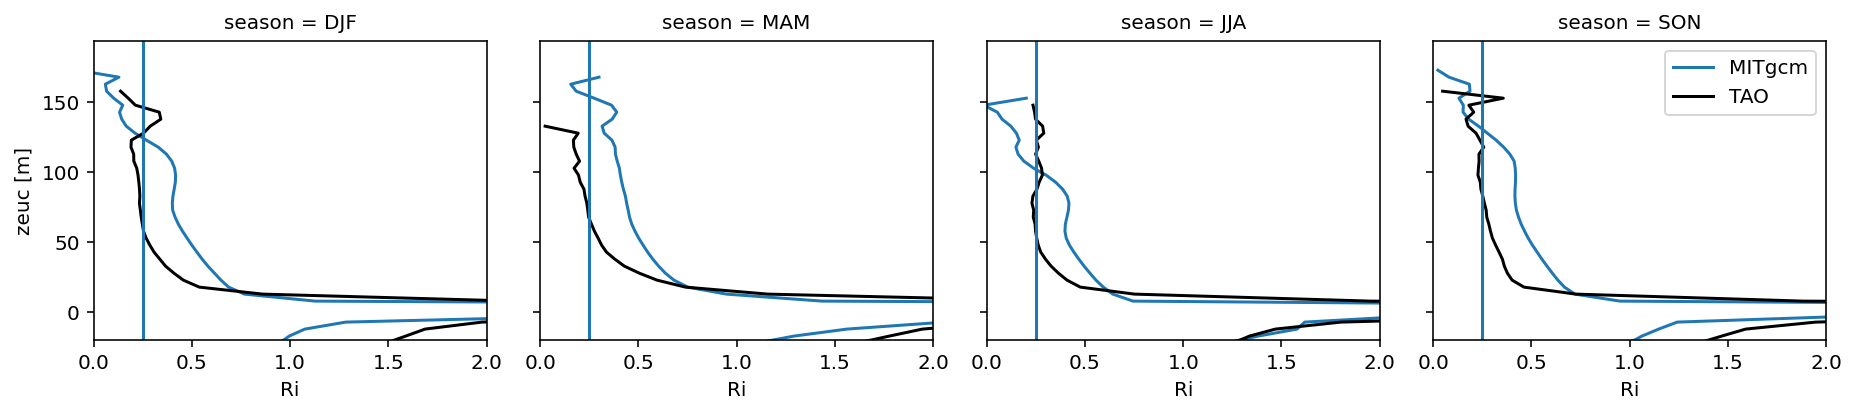

In [ ]:
fg = (
    remapped.Ri.groupby("time.season").median()
    .reindex(season=["DJF", "MAM", "JJA", "SON"])
    .cf.plot(col="season", xlim=(0, 2), ylim=(-20, None), label="MITgcm")
)
fg.data = tao_Ri.cf.sel(quantile=0.5, longitude=-140)
fg.map_dataarray_line(xr.plot.line, x=None, y="zeuc", hue="season", color='k', label="TAO")
fg.map(lambda: plt.axvline(0.25))
fg.axes[-1, -1].legend()

## Stability diagram: N2-S2 plane

Warner & Moum (2019):
> Both velocity and temperature are hourly averaged before interpolation to 5-m vertical bins

### All data

## Stability Diagram

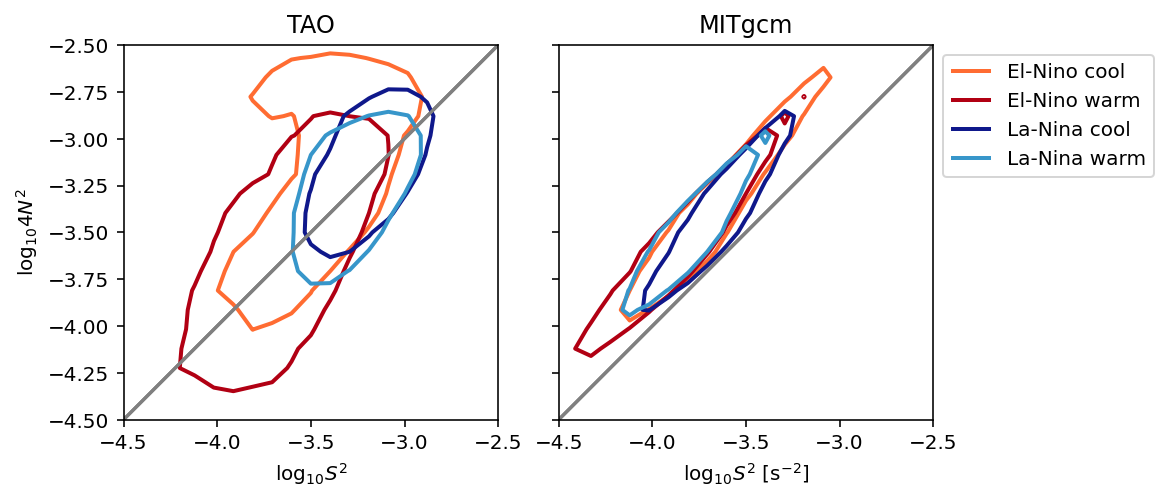

In [ ]:
mixpods.plot_stability_diagram_by_dataset(tao_gridded, simulations)

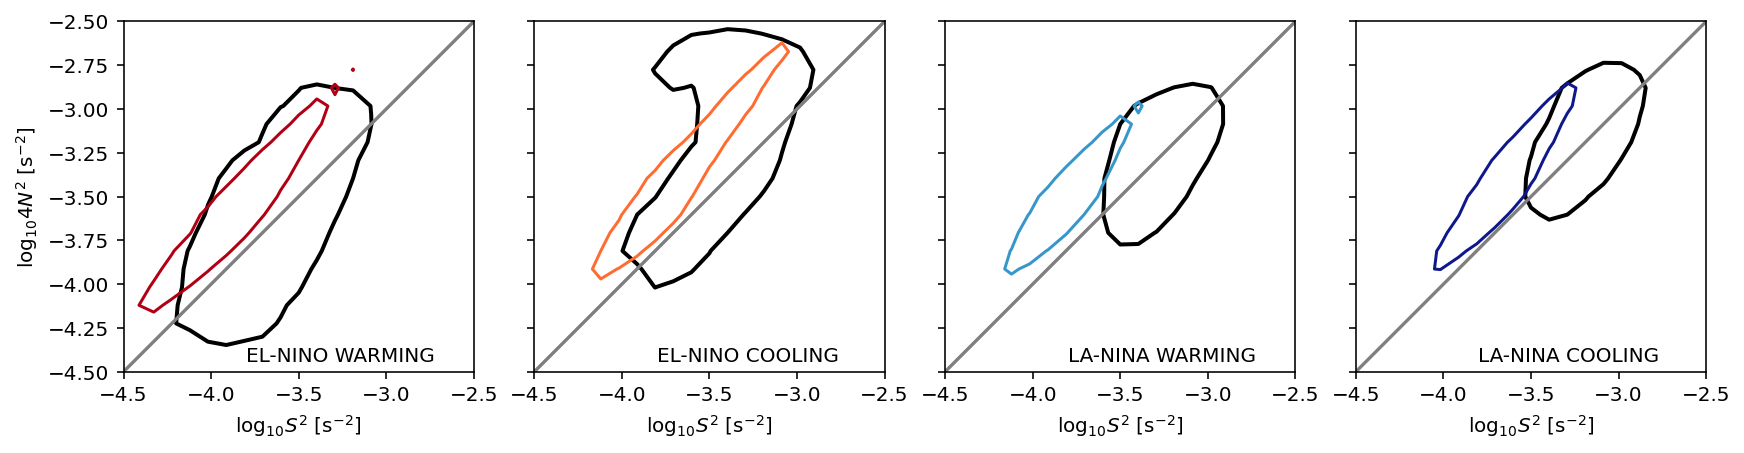

In [ ]:
mixpods.plot_stability_diagram_by_phase(tao_gridded, simulations, fig=None)

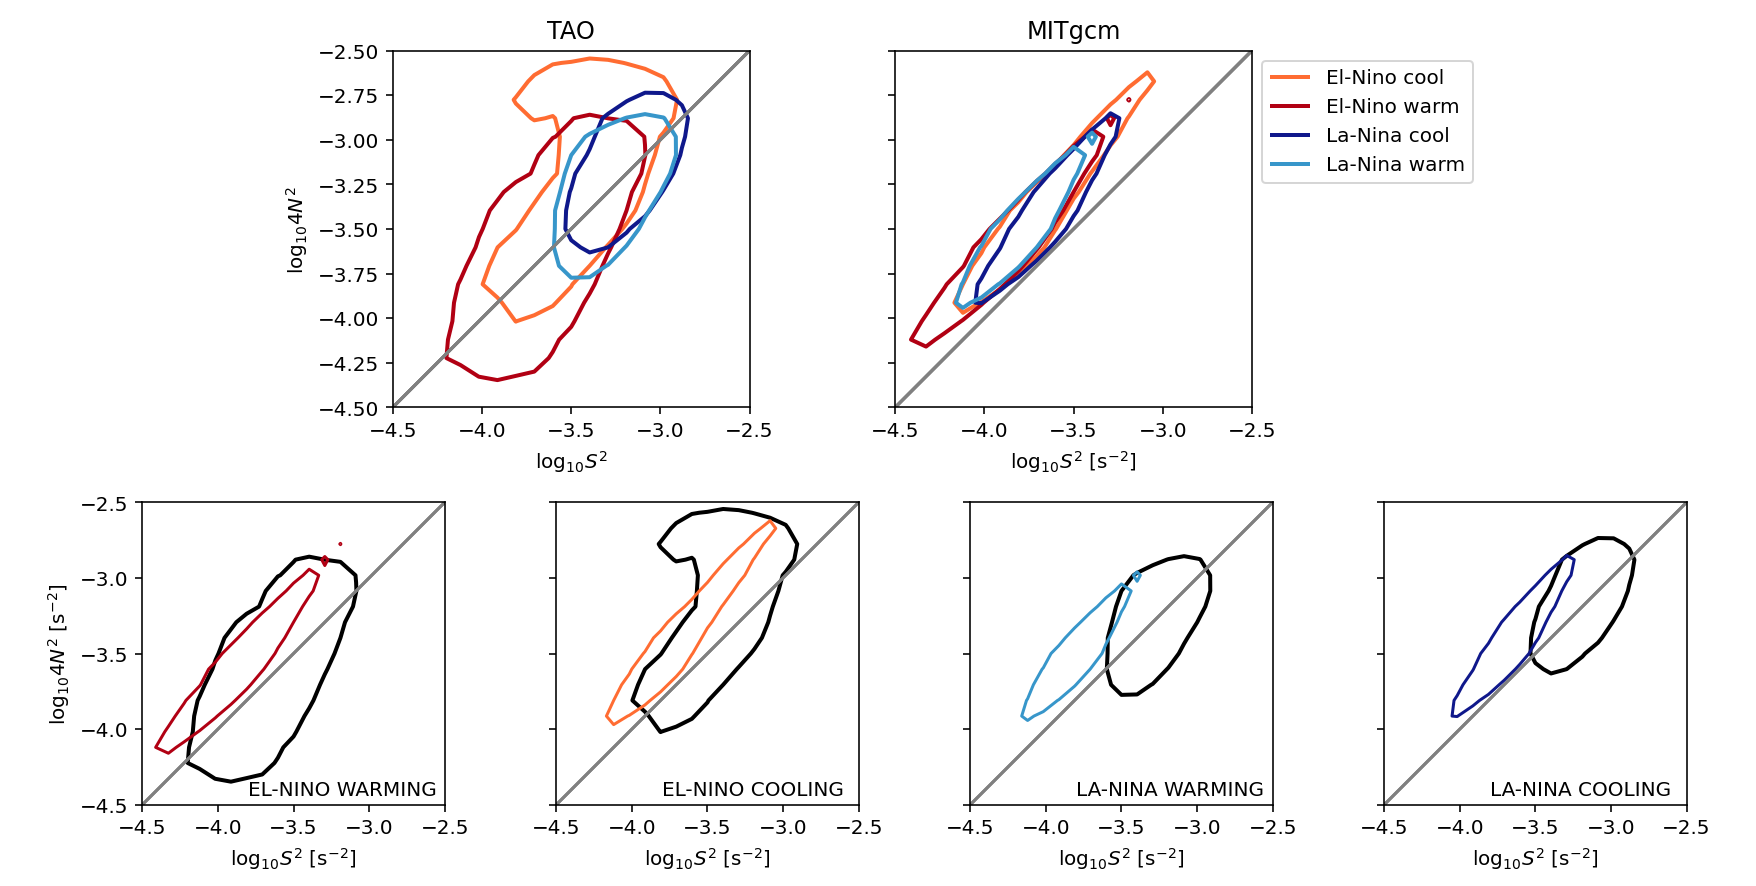

In [ ]:
fig = plt.figure(constrained_layout=True, figsize=(12, 6))
subfigs = fig.subfigures(2, 1, height_ratios=[1.2, 1])
top = subfigs[0].subfigures(1, 3, width_ratios=[1, 5, 1])

plot_stability_diagram_by_dataset(tao_gridded, simulations, fig=top[1])
plot_stability_diagram_by_phase(tao_gridded, simulations, fig=subfigs[1])

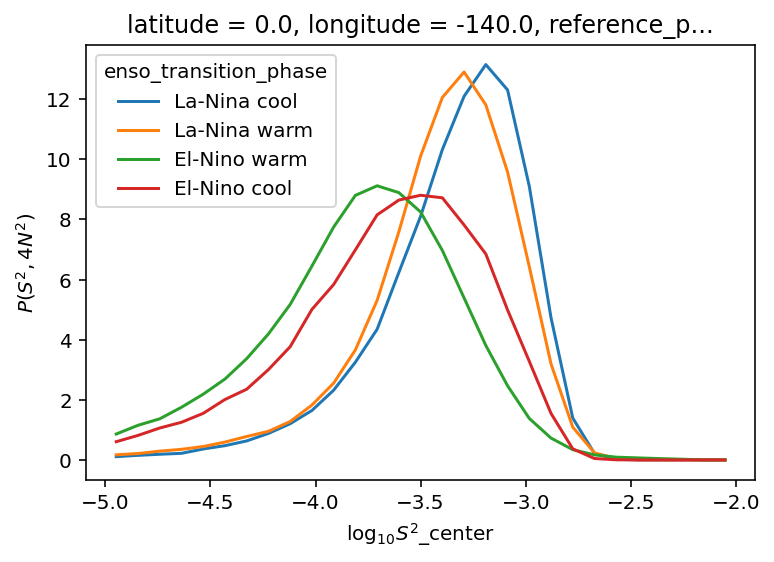

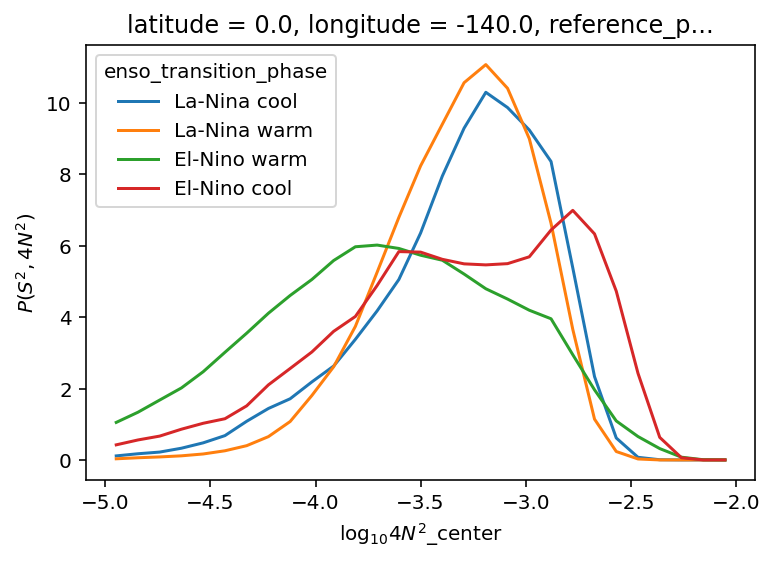

In [ ]:
(   
    tao_gridded.n2s2pdf
    .sel(enso_transition_phase=["La-Nina cool", "La-Nina warm", "El-Nino warm", "El-Nino cool"])
    .sum("N2_bins")
    .plot(hue="enso_transition_phase")
)
plt.figure()
(
    tao_gridded.n2s2pdf
    .sel(enso_transition_phase=["La-Nina cool", "La-Nina warm", "El-Nino warm", "El-Nino cool"])
    .sum("S2_bins")
    .plot(hue="enso_transition_phase")
)

In [ ]:
oni = pump.obs.process_oni().sel(time=slice("2005-Oct", "2015"))
(
    oni.hvplot.step(color='k')
+ pump.obs.make_enso_transition_mask().sel(time=slice("2005-Jun", "2015")).reset_coords(drop=True).hvplot.step()
).cols(1)

:Layout
   .Curve.I  :Curve   [time]   (index)
   .Curve.II :Curve   [time]   (enso_phase)

## Seasonal mean heat flux

In [ ]:
remapped.Jq.load()

<xarray.DataArray 'Jq' (time: 174000, zeuc: 100)>
array([[        nan,         nan, -0.07841657, ...,         nan,
                nan,         nan],
       [        nan,         nan, -0.07973828, ...,         nan,
                nan,         nan],
       [        nan,         nan, -0.08094554, ...,         nan,
                nan,         nan],
       ...,
       [        nan, -0.07447129,         nan, ...,         nan,
                nan,         nan],
       [        nan, -0.07471326,         nan, ...,         nan,
                nan,         nan],
       [        nan, -0.07509062,         nan, ...,         nan,
                nan,         nan]])
Coordinates:
    latitude   float64 0.025
    longitude  float64 -140.0
  * time       (time) datetime64[ns] 1998-12-31T18:00:00 ... 2018-11-06T17:00:00
  * zeuc       (zeuc) float64 -247.5 -242.5 -237.5 -232.5 ... 237.5 242.5 247.5

In [ ]:
import hvplot.xarray

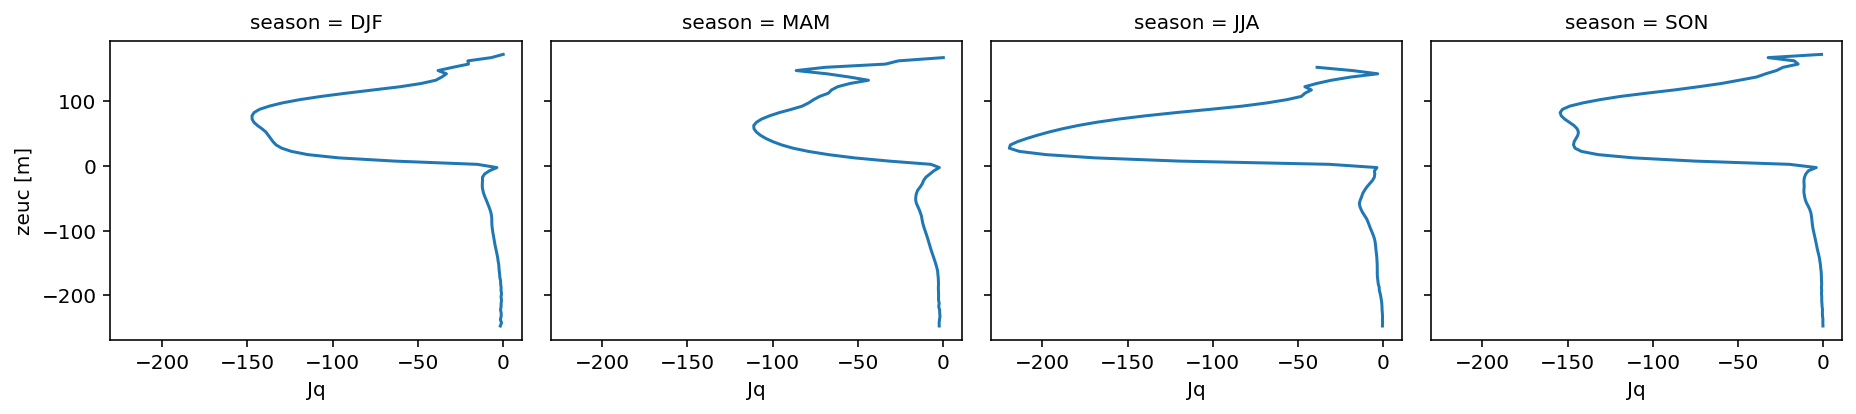

In [ ]:
(
    remapped.Jq.groupby("time.season").mean()
    .reindex(season=["DJF", "MAM", "JJA", "SON"])
    .cf.plot.line(col="season")
)

## LES

In [ ]:
may = pump.les.read_les_file(
    "../datasets/les_post_process/ROMS_PSH_3HRLIN_242_602_360x360x288_25MAY1985_24NOV2021.nc"
)
may

<xarray.Dataset>
Dimensions:       (z: 288, time: 1313)
Coordinates:
  * z             (z) float64 -143.5 -143.0 -142.5 -142.0 ... -1.5 -1.0 -0.5 0.0
  * time          (time) datetime64[ns] 1985-05-25T03:00:00 ... 1985-05-30T00...
    alpha         float64 ...
    beta          float64 ...
    T0            float64 ...
    S0            float64 ...
    dz            float64 0.5
Data variables: (12/67)
    ume           (time, z) float32 ...
    vme           (time, z) float32 ...
    tempme        (time, z) float32 ...
    saltme        (time, z) float32 ...
    urms          (time, z) float32 ...
    vrms          (time, z) float32 ...
    ...            ...
    chi           (time, z) float32 2.227e-08 -2.505e-10 ... 1.66e-08 nan
    tke           (time, z) float32 4.914e-12 4.067e-12 ... 0.0003075 nan
    Rif           (time, z) float64 nan nan nan nan nan ... nan nan nan nan nan
    Reb           (time, z) float32 nan 0.01892 0.01975 0.02009 ... nan nan nan
    Jq            (time, z) float64 -31.12 0.3899 0.3944 ... -23.48 -117.2 nan
    eucmax        (time) float64 -95.0 -95.0 -95.0 -95.0 ... -92.5 -92.5 -92.5
Attributes:
    type:     DIABLO LES, processed means
    title:    ROMS_PSH_6HRLIN_0N140W_360x360x288_5OCT2021
    history:  Tue Dec 28 09:09:16 2021: ncatted -O -a units,time,m,c,seconds ...
    NCO:      netCDF Operators version 4.9.5 (Homepage = http://nco.sf.net, C...

In [ ]:
octo = pump.les.read_les_file(
    "../datasets/les_post_process/ROMS_PSH_6HRLIN_0N140W_360x360x216_22OCT2020.nc"
)
octo

<xarray.Dataset>
Dimensions:       (z: 216, time: 8774)
Coordinates:
  * z             (z) float64 -107.5 -107.0 -106.5 -106.0 ... -1.5 -1.0 -0.5 0.0
  * time          (time) datetime64[ns] 1985-10-02T06:00:00 ... 1985-11-05T20...
    alpha         float64 ...
    beta          float64 ...
    T0            float64 ...
    S0            float64 ...
    dz            float64 0.5
Data variables: (12/67)
    ume           (time, z) float32 ...
    vme           (time, z) float32 ...
    tempme        (time, z) float32 ...
    saltme        (time, z) float32 ...
    urms          (time, z) float32 ...
    vrms          (time, z) float32 ...
    ...            ...
    chi           (time, z) float32 1.062e-08 -6.989e-10 ... -2.423e-07 nan
    tke           (time, z) float32 4.914e-08 4.067e-08 ... 0.0001316 nan
    Rif           (time, z) float64 nan nan nan nan nan ... nan nan nan nan nan
    Reb           (time, z) float32 nan 8.843 9.495 9.885 ... nan nan nan nan
    Jq            (time, z) float64 -11.26 0.6191 0.5909 ... -12.06 -79.09 nan
    eucmax        (time) float64 nan nan nan nan ... -104.0 -104.0 -104.0 -104.0
Attributes:
    type:     DIABLO LES, processed means
    title:    ROMS_PSH_6HRLIN_0N140W_360x360x216_22OCT2020

In [ ]:
may["n2s2pdf"] = mixpods.pdf_N2S2(may)
octo["n2s2pdf"] = mixpods.pdf_N2S2(octo)

/glade/u/home/dcherian/miniconda3/envs/pump/lib/python3.10/site-packages/xarray/core/computation.py:771: RuntimeWarning: invalid value encountered in log10
  result_data = func(*input_data)
/glade/u/home/dcherian/miniconda3/envs/pump/lib/python3.10/site-packages/xarray/core/computation.py:771: RuntimeWarning: invalid value encountered in log10
  result_data = func(*input_data)


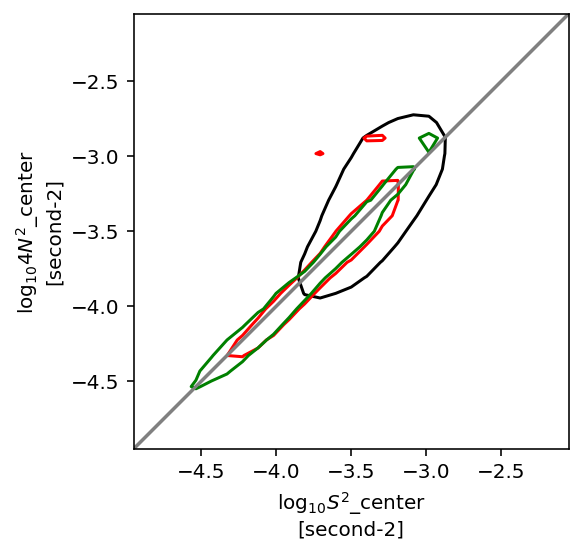

In [ ]:
for ds, color in zip([tao_gridded, octo, may], ["k", "r", "g"]):
    plot_n2s2pdf(ds.n2s2pdf.sel(enso_transition_phase="none"),  colors=color, targets=0.5, pcolor=False)